### EDA 2018

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
spark = SparkSession.builder.appName('2018-EDA').getOrCreate()

#change configuration settings on Spark 
conf = spark.sparkContext._conf.setAll([('spark.executor.memory', '4g'), ('spark.app.name', 'Spark Updated Conf'), ('spark.executor.cores', '4'), ('spark.cores.max', '4'), ('spark.driver.memory','4g')])

#print spark configuration settings
spark.sparkContext.getConf().getAll()

[('spark.stage.maxConsecutiveAttempts', '10'),
 ('spark.dynamicAllocation.minExecutors', '1'),
 ('spark.eventLog.enabled', 'true'),
 ('spark.submit.pyFiles',
  '/root/.ivy2/jars/com.johnsnowlabs.nlp_spark-nlp_2.12-4.4.0.jar,/root/.ivy2/jars/graphframes_graphframes-0.8.2-spark3.1-s_2.12.jar,/root/.ivy2/jars/com.typesafe_config-1.4.2.jar,/root/.ivy2/jars/org.rocksdb_rocksdbjni-6.29.5.jar,/root/.ivy2/jars/com.amazonaws_aws-java-sdk-bundle-1.11.828.jar,/root/.ivy2/jars/com.github.universal-automata_liblevenshtein-3.0.0.jar,/root/.ivy2/jars/com.google.cloud_google-cloud-storage-2.16.0.jar,/root/.ivy2/jars/com.navigamez_greex-1.0.jar,/root/.ivy2/jars/com.johnsnowlabs.nlp_tensorflow-cpu_2.12-0.4.4.jar,/root/.ivy2/jars/it.unimi.dsi_fastutil-7.0.12.jar,/root/.ivy2/jars/org.projectlombok_lombok-1.16.8.jar,/root/.ivy2/jars/com.google.guava_guava-31.1-jre.jar,/root/.ivy2/jars/com.google.guava_failureaccess-1.0.1.jar,/root/.ivy2/jars/com.google.guava_listenablefuture-9999.0-empty-to-avoid-conflict-

In [25]:
df_2018 = spark.read.csv("gs://msca-bdp-student-gcs/bdp-rideshare-project/rideshare/2018", inferSchema=True, header=True)


In [26]:
#display number of records by partition
def displaypartitions(df):
    #number of records by partition
    num = df.rdd.getNumPartitions()
    print("Partitions:", num)
    df.withColumn("partitionId", F.spark_partition_id())\
        .groupBy("partitionId")\
        .count()\
        .orderBy(F.asc("count"))\
        .show(num)

df_2018.rdd.getNumPartitions()

displaypartitions(df_2018)

Partitions: 35


+-----------+------+
|partitionId| count|
+-----------+------+
|         34| 74527|
|         21|504941|
|          5|505208|
|         17|505212|
|         26|506736|
|          1|506765|
|         10|507579|
|         25|508047|
|         16|509349|
|          9|509518|
|         33|510130|
|          8|510167|
|         24|510415|
|         29|510512|
|         22|510634|
|         20|510689|
|         15|511426|
|         19|511457|
|          6|511539|
|          4|511569|
|          0|511894|
|         28|512055|
|          3|512362|
|          2|512414|
|         32|512496|
|          7|512534|
|         27|512770|
|         11|512825|
|         23|513021|
|         13|513738|
|         18|514249|
|         14|515093|
|         30|515441|
|         12|519627|
|         31|524514|
+-----------+------+



In [27]:
#Find the number of missing values for each column
from pyspark.sql.functions import isnan, when, count, col
# don't run for loops on the data, running for loops on the columns is fine, doing it on the entire data can cause problems. 
df_2018.select([count(when(df_2018[c].isNull(), c)).alias(c) for c in df_2018.columns]).show()

+-------+--------------------+------------------+------------+----------+-------------------+--------------------+---------------------+----------------------+----+---+------------------+----------+----------------------+------------+------------------------+-------------------------+------------------------+-------------------------+--------------------------+-------------------------+
|Trip ID|Trip Start Timestamp|Trip End Timestamp|Trip Seconds|Trip Miles|Pickup Census Tract|Dropoff Census Tract|Pickup Community Area|Dropoff Community Area|Fare|Tip|Additional Charges|Trip Total|Shared Trip Authorized|Trips Pooled|Pickup Centroid Latitude|Pickup Centroid Longitude|Pickup Centroid Location|Dropoff Centroid Latitude|Dropoff Centroid Longitude|Dropoff Centroid Location|
+-------+--------------------+------------------+------------+----------+-------------------+--------------------+---------------------+----------------------+----+---+------------------+----------+----------------------

In [6]:
#Approximate number of 2018 trips
from pyspark.sql.functions import approxCountDistinct

df_2018.select(approxCountDistinct("Trip ID", rsd = 0.01)).show()

23/11/16 01:30:48 WARN org.apache.spark.sql.catalyst.util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+------------------------------+
|approx_count_distinct(Trip ID)|
+------------------------------+
|                      17414220|
+------------------------------+



<AxesSubplot:>

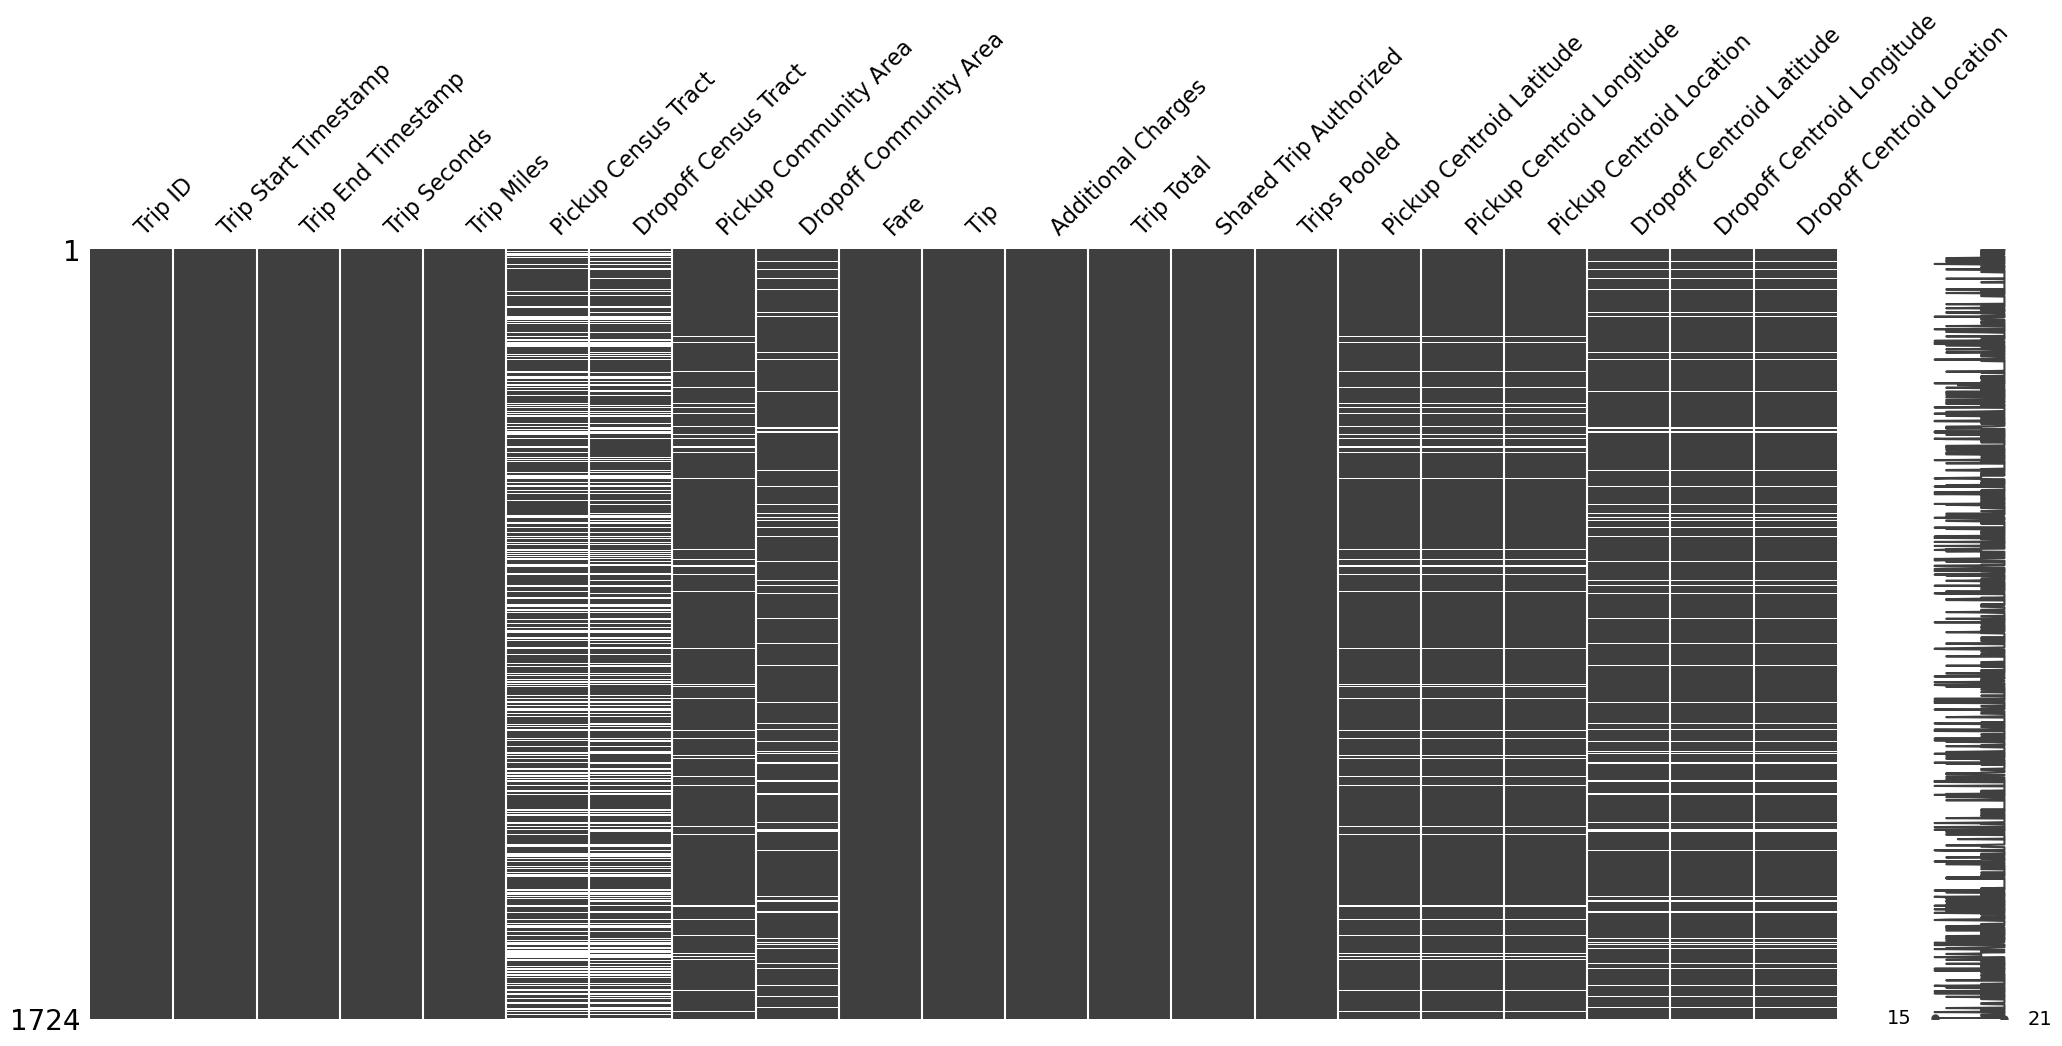

In [28]:
import missingno as msno
%matplotlib inline
msno.matrix(df_2018.sample(fraction=1/10000).toPandas())

In [29]:
df_2018 = df_2018.dropna(how='any')
df_2018 = df_2018.dropDuplicates()

In [30]:
# Convert 'Trip start timestamp' and 'Trip End Timestamp' columns to timestamp
df_2018 = df_2018.withColumn("Trip Start Timestamp", F.to_timestamp(F.col("Trip Start Timestamp"), "MM/dd/yyyy hh:mm:ss a"))
df_2018 = df_2018.withColumn("Trip End Timestamp", F.to_timestamp(F.col("Trip End Timestamp"), "MM/dd/yyyy hh:mm:ss a"))

In [31]:
df_2018 = df_2018.drop('Trips Pooled','Additional Charges','Pickup Centroid Location','Dropoff Centroid Location')
df_2018 = df_2018.withColumnRenamed("Trip ID","ID").withColumnRenamed("Trip Start Timestamp","start_timestamp").withColumnRenamed("Trip End Timestamp","end_timestamp").withColumnRenamed("Trip Miles",\
                "miles").withColumnRenamed("Pickup Census Tract","pickup_tract").withColumnRenamed("Dropoff Census Tract","dropoff_tract").withColumnRenamed("Pickup Community Area","pickup_area"\
                ).withColumnRenamed("Dropoff Community Area","dropoff_area").withColumnRenamed("Trip Total","total").withColumnRenamed("Pickup Centroid Latitude","pickup_lat").withColumnRenamed(\
                "Pickup Centroid Longitude","pickup_lon").withColumnRenamed("Pickup Centroid Location","pickup_location").withColumnRenamed("Dropoff Centroid Latitude","dropoff_lat").withColumnRenamed(\
                "Dropoff Centroid Longitude","dropoff_lon").withColumnRenamed("Dropoff Centroid Latitude", "dropoff_lat").withColumnRenamed("Trip Seconds", "trip_seconds").withColumnRenamed("Dropoff Centroid Location", "dropoff_location").withColumnRenamed("Fare", "fare")

In [32]:
df_2018 = df_2018.withColumn('date_only', F.to_date(df_2018.end_timestamp))
# add the month column
df_2018 = df_2018.withColumn('month', F.month(df_2018.start_timestamp))
df_2018 = df_2018.withColumn('hour', F.hour(df_2018.start_timestamp))
df_2018 = df_2018.withColumn('day_of_month', F.dayofmonth(df_2018.start_timestamp))
df_2018 = df_2018.withColumn('day', F.dayofweek(df_2018.start_timestamp))

In [33]:
sample_df = df_2018.sample(fraction=1/10000).toPandas().loc[:,["pickup_area","dropoff_area","total","Fare","Tip","total","miles","seconds","hour","day","month"]]
sample_df = sample_df.dropna()
sample_df = sample_df.drop_duplicates()

KeyError: "Passing list-likes to .loc or [] with any missing labels is no longer supported. The following labels were missing: Index(['Fare', 'seconds'], dtype='object'). See https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike"

In [ ]:
import seaborn as sns

sns.displot(sample_df, x="miles")


In [ ]:
sns.displot(sample_df, x="seconds")


In [ ]:
sns.displot(sample_df, x="Fare")


In [ ]:
sns.displot(sample_df, x="Tip")

In [11]:
# get rides that occurred within hyde park
# add kenwood and woodlawn to this list - only if the other location is hyde park                    
df_hp = df_2018.filter((df_2018.pickup_area == 41) & (df_2018.dropoff_area == 41))
df_kw = df_2018.filter(((df_2018.pickup_area == 41) & (df_2018.dropoff_area == 42)) | ((df_2018.pickup_area == 42) & (df_2018.dropoff_area == 41)))
df_wl = df_2018.filter(((df_2018.pickup_area == 41) & (df_2018.dropoff_area == 39)) | ((df_2018.pickup_area == 39) & (df_2018.dropoff_area == 41)))
df_area = df_hp.union(df_kw).union(df_wl)

<AxesSubplot:xlabel='month'>

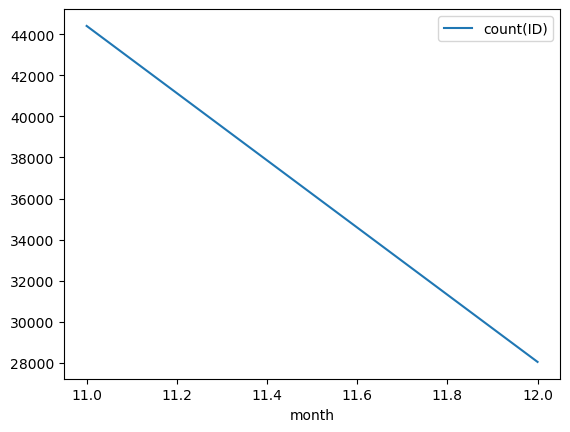

In [16]:
df_area.groupby("month").agg({'ID':'count'}).orderBy(F.col('month').asc()).toPandas().plot(x="month",y="count(ID)")

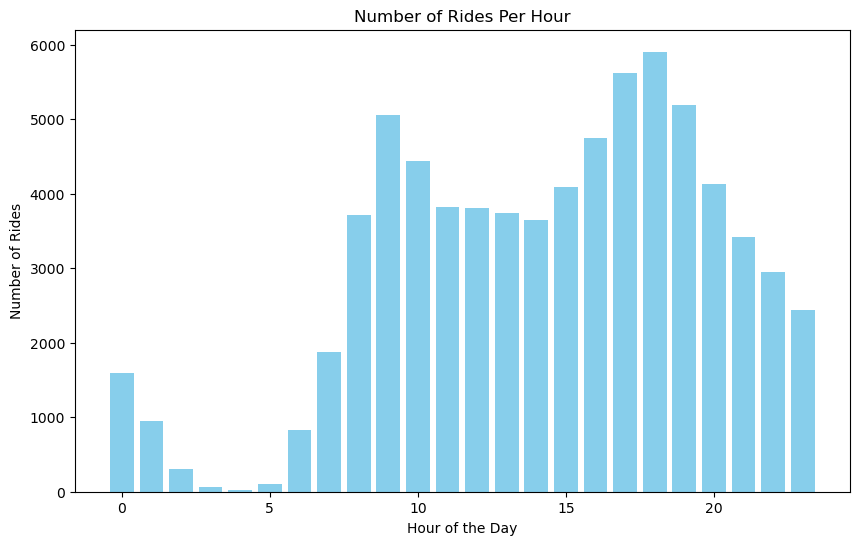

In [13]:
# rides per hour:
rides_per_hour = df_area.groupBy("hour").count().orderBy("hour")

# Convert the result to Pandas for local plotting
rides_per_hour_pd = rides_per_hour.toPandas()

# Plot the data
plt.figure(figsize=(10, 6))
plt.bar(rides_per_hour_pd["hour"], rides_per_hour_pd["count"], color="skyblue")
plt.xlabel("Hour of the Day")
plt.ylabel("Number of Rides")
plt.title("Number of Rides Per Hour")
plt.show()

In [14]:
df_area_program = df_area.filter((df_area.fare <= 15.0) & ((df_area.hour >= 17) | (df_area.hour < 4)))

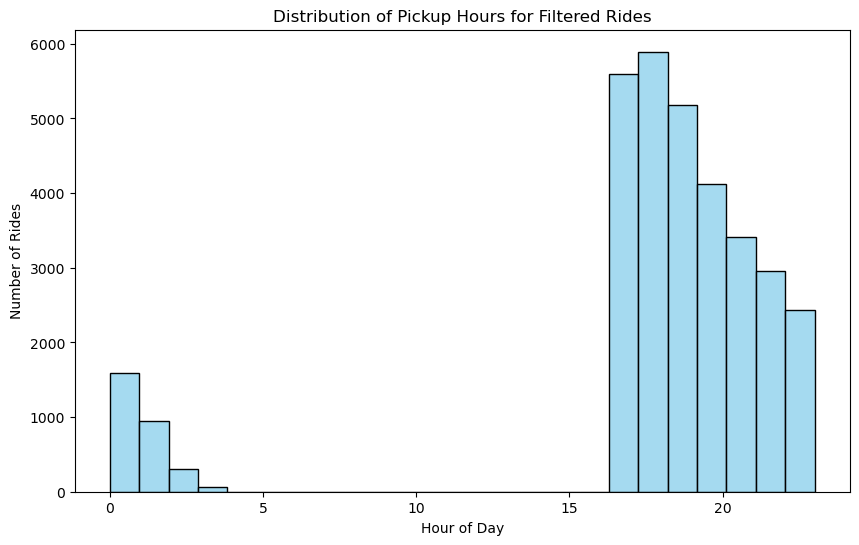

In [15]:
import seaborn as sns

df_area_program_pd = df_area_program.toPandas()

plt.figure(figsize=(10, 6))
sns.histplot(df_area_program_pd['hour'], bins=24, kde=False, color='skyblue')
plt.title('Distribution of Pickup Hours for Filtered Rides')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Rides')
plt.show()


In [24]:
df_total = df_2018.groupby("pickup_area").agg({'ID':'count'}).orderBy(F.col('pickup_area').asc()).toPandas()
%matplotlib inline
plt.figure(figsize=(10, 10))
ax = df_total.plot(x="pickup_area",y="count(ID)", kind='bar')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.show()

root
 |-- ID: string (nullable = true)
 |-- start_timestamp: timestamp (nullable = true)
 |-- end_timestamp: timestamp (nullable = true)
 |-- trip_seconds: integer (nullable = true)
 |-- miles: double (nullable = true)
 |-- pickup_tract: long (nullable = true)
 |-- dropoff_tract: long (nullable = true)
 |-- pickup_area: integer (nullable = true)
 |-- dropoff_area: integer (nullable = true)
 |-- fare: double (nullable = true)
 |-- total: double (nullable = true)
 |-- pickup_lat: double (nullable = true)
 |-- pickup_lon: double (nullable = true)
 |-- pickup_location: string (nullable = true)
 |-- dropoff_lat: double (nullable = true)
 |-- dropoff_lon: double (nullable = true)
 |-- dropoff_location: string (nullable = true)
 |-- date_only: date (nullable = true)
 |-- month: integer (nullable = true)
 |-- hour: integer (nullable = true)



In [ ]:
df_2018.groupby("dropoff_area").agg({'ID':'count'}).orderBy(F.col('dropoff_area').asc()).toPandas().plot(x="dropoff_area",y="count(ID)", kind='bar')

In [ ]:
# storing data on the bucket
df_area_program.write.option("header", "true").csv("gs://msca-bdp-student-gcs/bdp-rideshare-project/rideshare/processed_data/program_area_time_rides_2018.csv")
df_2018.write.option("header", "true").csv("gs://msca-bdp-student-gcs/bdp-rideshare-project/rideshare/processed_data/rides_2018.csv")